# Autotalker Tutorial

Created by Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).

## 1. Setup

### 1.1 Import Libraries

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import argparse
import os
from datetime import datetime

import matplotlib
import mlflow
import numpy as np
import scanpy as sc
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.benchmarking import (compute_avg_ctad_metric,
                                     compute_min_lnmi_metric)
from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions)

In [3]:
# Define default matplotlib figure size
matplotlib.rcParams['figure.figsize'] = (20, 10)

# 1.2 Configure Paths and Create Directories

In [4]:
# Mlflow
os.makedirs("mlruns", exist_ok=True)

# Gene program data
gp_data_folder_path = "datasets/gp_data"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"
os.makedirs(gp_data_folder_path, exist_ok=True)

### 1.3 Define Parameters

In [5]:
random_state = 42
dataset = "squidpy_seqfish"
radius = 0.05 # 30.0 for slideseqv2
# node_label_method = "self"
# node_label_method = "one-hop-sum"
node_label_method = "one-hop-norm"
# node_label_method = "one-hop-attention"
n_latent_fc_gps = 512
edge_batch_size = 32 # training did not work when too small

## 2. Load Data

In [6]:
print(f"Using dataset {dataset}.")

if dataset == "deeplinc_seqfish":
    adata = load_spatial_adata_from_csv(counts_file_path="datasets/seqFISH/counts.csv",
                                        adj_file_path="datasets/seqFISH/adj.csv",
                                        cell_type_file_path="datasets/seqFISH/cell_types.csv",
                                        cell_type_col="Cell_class_name")
    cell_type_key = "cell_type"
elif dataset == "squidpy_seqfish":
    adata = sq.datasets.seqfish()
    sq.gr.spatial_neighbors(adata, radius=radius, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"
elif dataset == "squidpy_slideseqv2":
    adata = sq.datasets.slideseqv2()
    sq.gr.spatial_neighbors(adata, radius=radius, coord_type="generic")
    cell_type_key = "cluster"
    
adata.layers["counts"] = adata.X.copy()

Using dataset squidpy_seqfish.


In [7]:
print(f"Number of nodes: {adata.layers['counts'].shape[0]}")
print(f"Number of node features: {adata.layers['counts'].shape[1]}")
avg_edges_per_node = round(
    adata.obsp['spatial_connectivities'].toarray().sum(axis=0).mean(),2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(np.triu(adata.obsp['spatial_connectivities'].toarray()).sum())
print(f"Number of edges: {n_edges}", sep="")

Number of nodes: 19416
Number of node features: 351
Average number of edges per node: 7.66
Number of edges: 74329


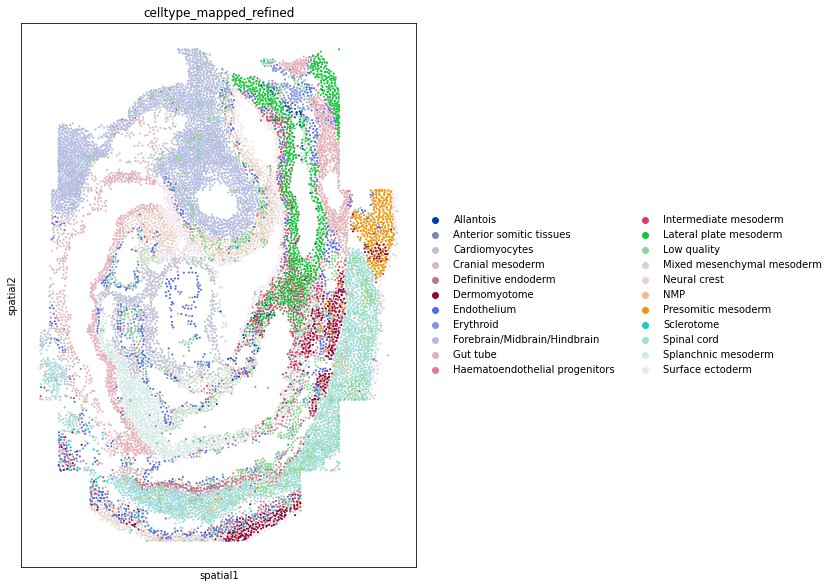

In [8]:
# Plot spatial data colored by cell types
sc.pl.spatial(adata, color="celltype_mapped_refined", spot_size=0.03)

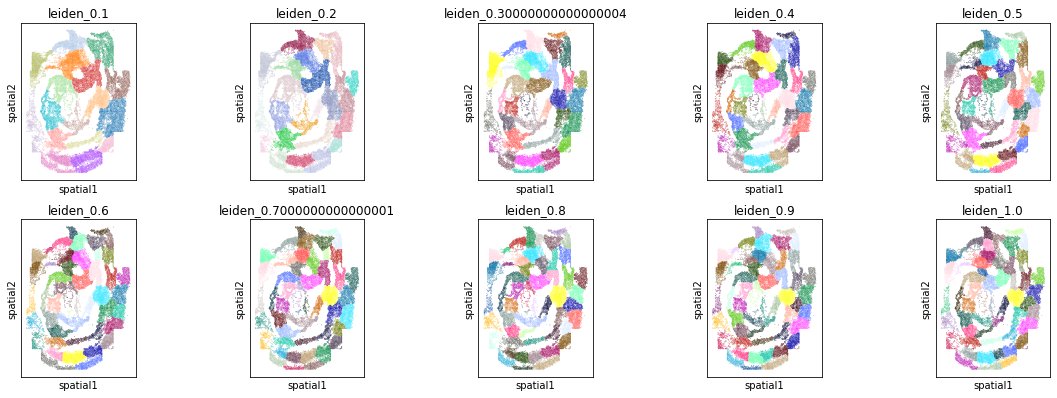

In [9]:
# Calculate adjacency matrix for Leiden clustering
sq.gr.spatial_neighbors(adata,
                        spatial_key="spatial",
                        coord_type="generic",
                        key_added="leiden",
                        n_neighs=6)

# Calculate Leiden clustering
clustering_resolutions = np.linspace(0.1, 1.0, 10)
for resolution in clustering_resolutions:
    sc.tl.leiden(adata,
                 resolution=resolution,
                 random_state=random_state,
                 key_added=f"leiden_{resolution}",
                 adjacency=adata.obsp["leiden_connectivities"])

# Plot Leiden clustering
with rc_context({"figure.figsize": (3, 3)}):
    sc.pl.spatial(adata,
                  color=[f"leiden_{resolution}" for resolution in clustering_resolutions],
                  ncols=5,
                  spot_size=0.03,
                  legend_loc=None)

In [10]:
sq.gr.nhood_enrichment(adata, cluster_key="celltype_mapped_refined")
# sq.pl.nhood_enrichment(adata, cluster_key="celltype_mapped_refined", method="ward")

  0%|          | 0/1000 [00:00<?, ?/s]

In [11]:
enrichment_scores = adata.uns['celltype_mapped_refined_nhood_enrichment']['zscore']
enrichment_counts_true = enrichment_counts
enrichment_counts_diff = enrichment_counts - enrichment_counts_true
np.linalg.norm(enrichment_counts_diff, ord="fro")

NameError: name 'enrichment_counts' is not defined

In [12]:
sc.pp.neighbors(adata,
                use_rep="latent_autotalker_fc_gps",
                n_neighbors=7,
                random_state=random_state,
                key_added="latent")
sq.gr.nhood_enrichment(adata, connectivity_key="latent", cluster_key="celltype_mapped_refined", seed=random_state) # copy=True)

ValueError: Did not find latent_autotalker_fc_gps in `.obsm.keys()`. You need to compute it first.

In [13]:
adata.obsp["connectivities"]

KeyError: 'connectivities'

## 3. Autotalker Model with Fully Connected Gene Programs

### 3.1 Create Fully Connected Gene Program Mask

In [14]:
# Mask that allows all genes
if node_label_method == "self":
    n_output = len(adata.var)
    gp_targets_mask = np.ones((n_latent_fc_gps, n_output))
    print(f"gp_targets_mask shape: {gp_targets_mask.shape}")
elif node_label_method != "self":
    n_output = len(adata.var) * 2
    gp_targets_mask = np.ones((n_latent_fc_gps, int(n_output / 2)))
    gp_sources_mask = np.ones((n_latent_fc_gps, int(n_output / 2)))
    print(f"gp_targets_mask shape: {gp_targets_mask.shape}.")
    print(f"gp_sources_mask shape: {gp_sources_mask.shape}.")

gp_targets_mask shape: (512, 351).
gp_sources_mask shape: (512, 351).


### 3.2 Initialize, Train & Save Model

In [15]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key=None,
                   gp_sources_mask_key=None,
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=int(n_latent_fc_gps/2),
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=gp_targets_mask,
                   gp_sources_mask=(None if node_label_method == "self" else gp_sources_mask))

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True
NODE LABEL METHOD -> one-hop-norm
GCN ENCODER -> n_input: 351, n_hidden: 256, n_latent: 512, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 512, n_output: 702


In [16]:
experiment = mlflow.set_experiment("autotalker_fc_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=10,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=None) #experiment.experiment_id)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of training edges: 63181
Number of validation edges: 7432
Number of test edges: 3716

--- MODEL TRAINING ---
Epoch 1/10 |██------------------| 10.0% val_auroc_score: 0.9306; val_auprc_score: 0.9146; val_best_acc_score: 0.8605; val_best_f1_score: 0.8693; train_loss: 572.6557; train_edge_recon_loss: 0.9721; train_kl_loss: 0.4347; train_gene_expr_recon_loss: 571.2488; val_loss: 565.1998; val_edge_recon_loss: 0.4994; val_kl_loss: 0.4975; val_gene_expr_recon_loss: 564.2028
Epoch 2/10 |████----------------| 20.0% val_auroc_score: 0.9091; val_auprc_score: 0.8929; val_best_acc_score: 0.8282; val_best_f1_score: 0.8409; train_loss: 564.8746; train_edge_recon_loss: 0.4753; train_kl_loss: 0.5286; train_gene_expr_recon_loss: 563.8707; val_loss: 568.3493; val_edge_recon_loss: 0.4514; val_kl_loss: 0.5374; val_gene_expr_recon_loss: 567.3605
Epoch 3/10 |██████--------------| 30.0% val_auroc_score: 0.883

In [17]:
model.save(dir_path="./model_artefacts/autotalker_fc_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

In [ ]:
model = Autotalker.load(dir_path="./model_artefacts/autotalker_fc_gps",
                        adata=None,
                        adata_file_name="adata.h5ad")

### 3.3. Visualize Latent Gene Programs with scanpy

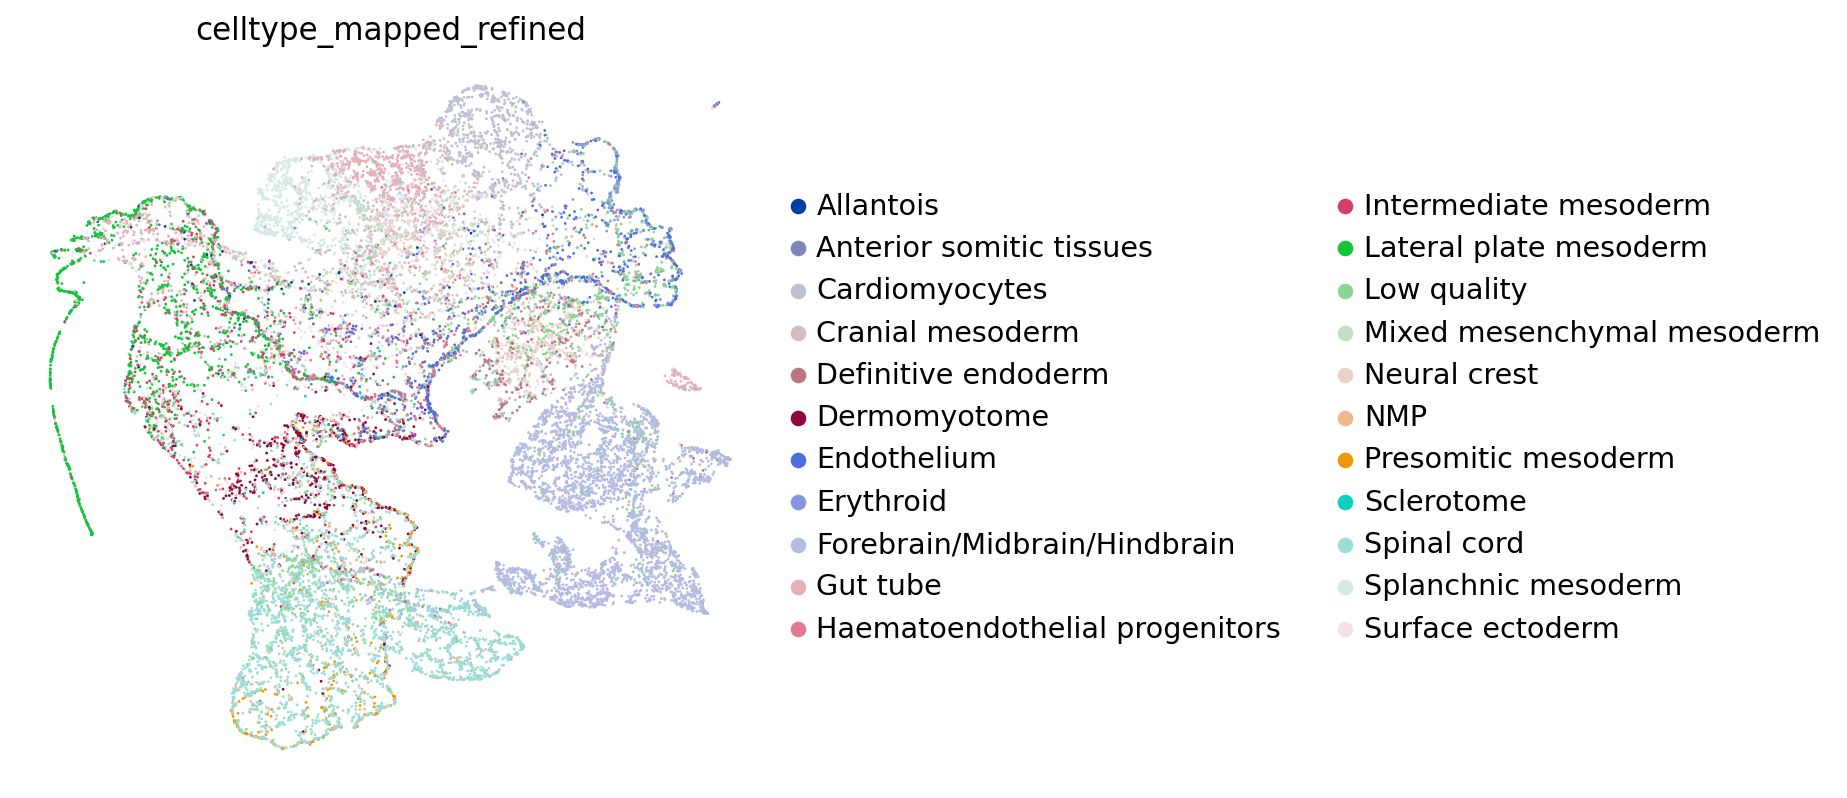

In [18]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_fc_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_fc_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_fc_gps_{current_time}.png")

## 4. Autotalker Model with Cell-Cell-Interaction (CCI) Gene Programs

### 4.1 NicheNet CCI Gene Programs

#### 4.1.1 Create NicheNet CCI Gene Program Mask

In [ ]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.1,
    load_from_disk=False,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [ ]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=nichenet_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_nichenet_gps_targets",
    gp_sources_varm_key="autotalker_nichenet_gps_sources",
    gp_names_uns_key="autotalker_nichenet_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
print(f"Number of gene programs: {len(adata.uns['autotalker_nichenet_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_nichenet_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_nichenet_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_nichenet_gps_sources'].sum()}.")

In [ ]:
nichenet_gps_targets_mask = torch.tensor(adata.varm["autotalker_nichenet_gps_targets"].T, dtype=torch.float32)
nichenet_gps_sources_mask = torch.tensor(adata.varm["autotalker_nichenet_gps_sources"].T, dtype=torch.float32)
nichenet_gps_mask = torch.cat((nichenet_gps_targets_mask, nichenet_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {nichenet_gps_mask.shape}.")
nichenet_gps_n_hidden_encoder = int(nichenet_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {nichenet_gps_n_hidden_encoder}.")

#### 4.1.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_nichenet_gps_targets",
                   gp_sources_mask_key="autotalker_nichenet_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=nichenet_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_nichenet_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=30,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id)

#### 4.1.3 Visualize Latent Gene Programs with scanpy

In [ ]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_nichenet_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_nichenet_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_nichenet_gps_{current_time}.png")

### 4.2 OmniPath CCI Gene Programs

#### 4.2.1 Create OmniPath CCI Gene Program Mask

In [ ]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [ ]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=omnipath_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_omnipath_gps_targets",
    gp_sources_varm_key="autotalker_omnipath_gps_sources",
    gp_names_uns_key="autotalker_omnipath_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
print(f"Number of gene programs: {len(adata.uns['autotalker_omnipath_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_omnipath_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_omnipath_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_omnipath_gps_sources'].sum()}.")

In [ ]:
omnipath_gps_targets_mask = torch.tensor(adata.varm["autotalker_omnipath_gps_targets"].T, dtype=torch.float32)
omnipath_gps_sources_mask = torch.tensor(adata.varm["autotalker_omnipath_gps_sources"].T, dtype=torch.float32)
omnipath_gps_mask = torch.cat((omnipath_gps_targets_mask, omnipath_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {omnipath_gps_mask.shape}.")
omnipath_gps_n_hidden_encoder = int(omnipath_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {omnipath_gps_n_hidden_encoder}.")

#### 4.2.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_omnipath_gps_targets",
                   gp_sources_mask_key="autotalker_omnipath_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=omnipath_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_omnipath_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=30,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id)

#### 4.2.3 Visualize Latent Gene Programs with scanpy

In [ ]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_omnipath_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_omnipath_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_omnipath_gps_{current_time}.png")

### 4.3 NicheNet & OmniPath CCI Gene Programs Combined

#### 4.3.1 Create Combined Gene Program Mask

In [ ]:
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)

In [ ]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=combined_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_combined_gps_targets",
    gp_sources_varm_key="autotalker_combined_gps_sources",
    gp_names_uns_key="autotalker_combined_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
print(f"Number of gene programs: {len(adata.uns['autotalker_combined_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_combined_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_combined_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_combined_gps_sources'].sum()}.")

In [ ]:
combined_gps_targets_mask = torch.tensor(adata.varm["autotalker_combined_gps_targets"].T, dtype=torch.float32)
combined_gps_sources_mask = torch.tensor(adata.varm["autotalker_combined_gps_sources"].T, dtype=torch.float32)
combined_gps_mask = torch.cat((combined_gps_targets_mask, combined_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {combined_gps_mask.shape}.")
combined_gps_n_hidden_encoder = int(combined_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {combined_gps_n_hidden_encoder}.")

#### 4.3.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_combined_gps_targets",
                   gp_sources_mask_key="autotalker_combined_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=combined_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_combined_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=30,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=32,
            grad_clip_value=5,
            mlflow_experiment_id=None)

#### 4.3.3 Visualize Latent Gene Programs with scanpy

In [ ]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_combined_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_combined_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_combined_gps_{current_time}.png")

The model can maintain the edge reconstruction performance while tweaking the latent space for better gene expression reconstruction.

In [ ]:
gene_programs = adata.uns["autotalker_combined_gps_names"]

In [ ]:
gene_programs = adata.uns["autotalker_combined_gps_names"]
selected_gene_programs = ["CSF1_ligand_targetgenes_GP", "IL34_ligand_targetgenes_GP"]
selected_gene_programs_idx = [gene_programs.index(gene_program) for gene_program in selected_gene_programs]

In [ ]:
latent_selected_gps = latent[:, selected_gene_programs_idx]

In [ ]:
adata.obs["CSF1_ligand_targetgenes_GP"] = latent_selected_gps[:, 0]
adata.obs["IL34_ligand_targetgenes_GP"] = latent_selected_gps[:, 1]

In [ ]:
sc.pl.umap(adata, color="CSF1_ligand_targetgenes_GP", frameon=False, wspace=0.6)

In [ ]:
sc.pl.scatter(adata, x="CSF1_ligand_targetgenes_GP", y="IL34_ligand_targetgenes_GP", color=cell_type_key, size=10)

### 5. Benchmarking

#### Cell-type Affinity Distance

In [71]:
for i in np.linspace(0.1, 1.0, 10, dtype=np.float32):
    print(i)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [48]:
avg_ctad = compute_avg_ctad_metric(adata=adata,
                                   cell_type_key="celltype_mapped_refined",
                                   spatial_key="spatial",
                                   latent_rep_key="latent_autotalker_fc_gps",
                                   seed=random_state)

In [50]:
avg_ctad

299.341814403882

#### Leiden Normalized Mutual Info 

In [83]:
min_lnmi = compute_min_lnmi_metric(adata=adata,
                                   spatial_key="spatial",
                                   latent_rep_key="latent_autotalker_fc_gps",
                                   seed=random_state)

In [84]:
min_lnmi

0.42374523716958956

In [26]:
adata.obsm["spatial"]

array([[ 0.72926073, -2.82174578],
       [ 0.70843688, -2.70712631],
       [ 0.96172602, -2.94395082],
       ...,
       [-1.51395795,  2.62545878],
       [-1.38935352,  3.13495082],
       [-1.39499228,  2.58127179]])

### 6. Comparison SCVI Model

In [ ]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(6, 6))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [ ]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts"
)

In [ ]:
model = scvi.model.SCVI(adata)

In [ ]:
model

In [ ]:
model.train()

In [ ]:
latent_scvi = model.get_latent_representation()

In [ ]:
adata.obsm["X_scVI"] = latent_scvi

In [ ]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
sc.pl.umap(adata, color=["celltype_mapped_refined"], frameon=False,)